# Tutorial Hierarchy analysis

This tutorial describes how to use the hierarchy function. This allows an user to identify for an expansions object to which "parent" object of the original mask.

In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import anndata as ad
import scanpy as sc
from natsort import natsorted
import numpy as np
np.random.seed(42)

sys.path.append(os.path.dirname(os.getcwd()))
import seaborn as sns
from gridgene import get_arrays as ga
from gridgene import contours, get_masks
from gridgene.mask_properties import MaskAnalysisPipeline, MaskDefinition

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

***Hierarchy using Constrained Mask Expansion***

We will use Cancer Stroma Interface analysis in Xenium. 

Get the files for Xenium

In [3]:
tma1_path = '../../xenium_data/HLA/GD_TMA1_S3/fov_filtered'
files_tma1 = os.listdir(tma1_path)


to_exclude = [
    'TMA1_Selection14_filtered.csv' , # little tumour
    'TMA1_Selection15_filtered.csv', # tonsil
    'TMA1_Selection18_filtered.csv' , # normal
    'TMA1_Selection24_filtered.csv', # tonsl 
    'TMA1_Selection27_filtered.csv', # low quality
    'TMA1_Selection32_filtered.csv', # low quality
    'TMA1_Selection33_filtered.csv', # low quality
             ]

files = [os.path.join(tma1_path, file) for file in files_tma1 if file not in to_exclude]
print(len(files))

20


***Derive cancer and stroma masks***

Apply GRIDGEN to Xenium to derive cancer and stroma masks (similar to the previous notebook: "Cancer Stroma in Xenium").

After this, expansions from the cancer mask inside the stroma mask are derived, and mask information is retrieved. We will expand 10 and 20 um.

In [4]:
# param tum
target_tum = ['EPCAM', 'SMIM22','CLDN3', 'KRT18','LGALS4', 'KRT8', 'ELF3','TSPAN8', 'STMN1', 'CD47', 'MYC', 'LGALS3'] 
density_th_tum = 10    
min_area_th_tum =  700 
kernel_size_tum = 10  
# param empty
density_th_empty = 40
min_area_th_empty = 400 
kernel_size_empty = 10

2025-06-19 23:51:29,534 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-19 23:51:29,623 - gridgen.contours.tum - INFO - get_conv_sum took 0.0886 seconds
2025-06-19 23:51:29,706 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 7
2025-06-19 23:51:29,707 - gridgen.contours.tum - INFO - contours_from_sum took 0.0829 seconds
2025-06-19 23:51:29,707 - gridgen.contours.empty - INFO - Initialized GetContour
2025-06-19 23:51:30,277 - gridgen.contours.empty - INFO - get_conv_sum took 0.5697 seconds
2025-06-19 23:51:30,843 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 29
2025-06-19 23:51:30,844 - gridgen.contours.empty - INFO - contours_from_sum took 0.5662 seconds
2025-06-19 23:51:30,844 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-19 23:51:30,859 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.


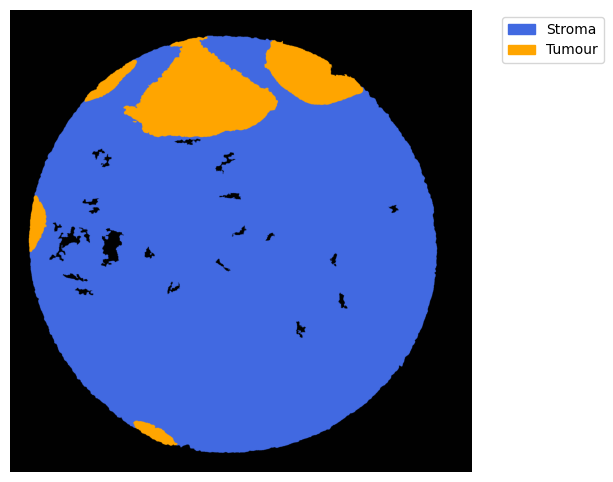

2025-06-19 23:51:31,143 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks


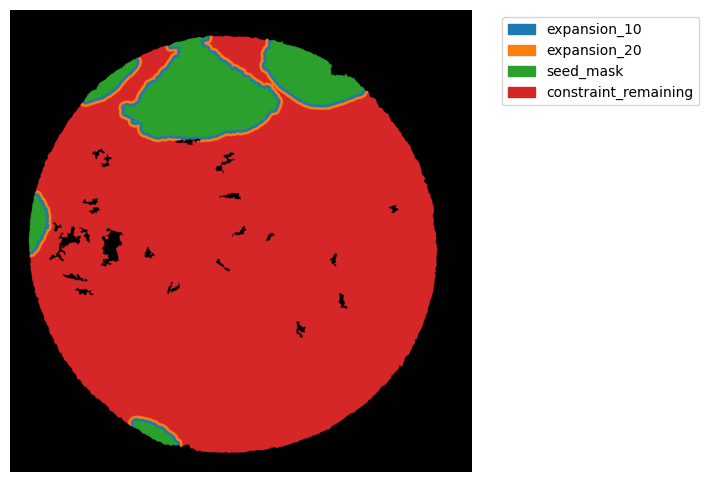

In [5]:
file_csv = files[9]
df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')

# obtain contours 
CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
CTum.contours_from_sum(density_threshold = density_th_tum,
                       min_area_threshold = min_area_th_tum , directionality = 'higher')

CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
CEmpty.contours_from_sum(density_threshold = density_th_empty,
                       min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 

#### obtain masks
GM = get_masks.GetMasks(image_shape = (height, width))

mask_empty = GM.create_mask(CEmpty.contours)
mask_tum = GM.create_mask(CTum.contours)
mask_tum = GM.fill_holes(mask_tum)
mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
mask_stroma = GM.filter_binary_mask_by_area(mask_stroma, min_area=700)

GM.plot_masks(masks=[mask_stroma, mask_tum], mask_names=['Stroma', 'Tumour'],
              background_color=(1, 1, 1), mask_colors={'Stroma': (65, 105, 225), 'Tumour': (255, 165, 0)},
              path=None, show=True, ax=None, figsize=(8, 6)) 

TA = get_masks.ConstrainedMaskExpansion(mask_tum, mask_stroma)
TA.expand_mask(expansion_pixels=[10,20], min_area=1000)
GM.plot_masks(masks=TA.binary_expansions.values(),
              mask_names=TA.binary_expansions.keys(),
              background_color=(1, 1, 1), mask_colors=None, path=None, show=True, ax=None,
             figsize=(8, 6))

We can extract the information from the masks
Pipeline run will extract counts and morphology

In [6]:
#  1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=TA.binary_expansions['constraint_remaining'], mask_name='Stroma_remaining', analysis_type='bulk'),
    MaskDefinition(mask=TA.binary_expansions['seed_mask'], mask_name='Cancer', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_10'], mask_name='CI_10um', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_20'], mask_name='CI_20um', analysis_type='per_object'),
]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df.head()

2025-06-19 23:51:31,890 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-19 23:51:31,890 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Stroma_remaining (bulk)
2025-06-19 23:51:32,825 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Cancer (per_object)
2025-06-19 23:51:33,356 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_10um (per_object)
2025-06-19 23:51:33,823 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_20um (per_object)


run took 2.3947 seconds


,area,object_id,IL6ST,IGHG1,COL1A1,CTSH,SIRPA,TIMP2,SPARC,LMO2,...,analysis_type,perimeter,eccentricity,solidity,centroid_y,centroid_x,min_row,min_col,max_row,max_col
0,1749628.0,bulk,5880,2682,20626,1271,1022,13634,31112,461,...,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9614.0,1,50,11,95,81,29,29,90,0,...,per_object,556.060967,0.954892,0.929607,104.747764,977.762118,74.0,865.0,145.0,1088.0
2,9459.0,2,68,22,59,96,44,24,56,0,...,per_object,617.961508,0.981762,0.908122,397.413046,1533.974627,294.0,1455.0,500.0,1621.0
3,136753.0,3,741,98,484,1649,499,586,796,66,...,per_object,2205.493650,0.734512,0.846480,749.492940,1472.664453,446.0,1316.0,1054.0,1713.0
4,7150.0,4,54,37,76,106,47,29,109,1,...,per_object,481.203102,0.965569,0.906555,568.757063,152.850629,485.0,103.0,659.0,202.0


 pipeline.map_hierarchies will map the hierarchy objects

In [7]:
hierarchy_defs = {
    "CI_10um": {
        "labels": TA.referenced_expansions['expansion_10'],
        "level_hierarchy": "Cancer"
    },
    "CI_20um": {
        "labels": TA.referenced_expansions['expansion_20'],
        "level_hierarchy": "Cancer"
    },
        "Cancer": {
        "labels": TA.referenced_expansions['seed_mask'],
        "level_hierarchy": "Cancer"
    }
}


df_hierarchy = pipeline.map_hierarchies(hierarchy_defs, save_dir=None)
df_hierarchy

map_hierarchies took 0.0556 seconds


,mask_name,object_id,parent_mask,parent_ids
0,CI_10um,1,Cancer,[1]
1,CI_10um,2,Cancer,[2]
2,CI_10um,3,Cancer,[3]
3,CI_10um,4,Cancer,[4]
4,CI_10um,5,Cancer,[5]
5,CI_20um,1,Cancer,[1]
6,CI_20um,2,Cancer,[2]
7,CI_20um,3,Cancer,[3]
8,CI_20um,4,Cancer,[4]
9,CI_20um,5,Cancer,"[3, 5]"


Lets check another example

2025-06-19 23:51:40,419 - gridgen.contours.tum - INFO - Initialized GetContour
2025-06-19 23:51:40,497 - gridgen.contours.tum - INFO - get_conv_sum took 0.0771 seconds
2025-06-19 23:51:40,569 - gridgen.contours.tum - INFO - Number of contours after filtering no counts: 25
2025-06-19 23:51:40,569 - gridgen.contours.tum - INFO - contours_from_sum took 0.0721 seconds
2025-06-19 23:51:40,570 - gridgen.contours.empty - INFO - Initialized GetContour
2025-06-19 23:51:41,128 - gridgen.contours.empty - INFO - get_conv_sum took 0.5579 seconds
2025-06-19 23:51:41,673 - gridgen.contours.empty - INFO - Number of contours after filtering no counts: 39
2025-06-19 23:51:41,674 - gridgen.contours.empty - INFO - contours_from_sum took 0.5453 seconds
2025-06-19 23:51:41,674 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-19 23:51:41,692 - gridgen.get_masks.GetMasks - INFO - Subtracted masks from base mask.
2025-06-19 23:51:41,766 - gridgen.get_masks.GetMasks - INFO - Initialized GetMas

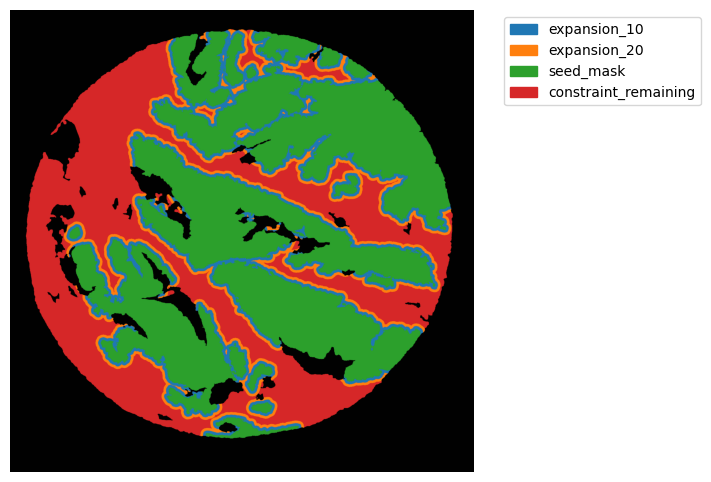

2025-06-19 23:51:42,491 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-19 23:51:42,494 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Stroma_remaining (bulk)
2025-06-19 23:51:43,017 - gridgen.mask_properties.GetMasks - INFO - Processing mask: Cancer (per_object)
2025-06-19 23:51:44,098 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_10um (per_object)
2025-06-19 23:51:45,018 - gridgen.mask_properties.GetMasks - INFO - Processing mask: CI_20um (per_object)


run took 3.5887 seconds
map_hierarchies took 0.2382 seconds


,mask_name,object_id,parent_mask,parent_ids
0,Cancer,1,Cancer,[1]
1,Cancer,2,Cancer,[2]
2,Cancer,3,Cancer,[3]
3,Cancer,4,Cancer,[4]
4,Cancer,5,Cancer,[5]
...,...,...,...,...
114,CI_20um,68,Cancer,[7]
115,CI_20um,69,Cancer,[4]
116,CI_20um,70,Cancer,[3]
117,CI_20um,71,Cancer,[3]


In [8]:
file_csv = files[15]
df_total = pd.read_csv(file_csv)
df_total = df_total[['x_location', 'y_location', 'feature_name']]
df_total = df_total.rename(columns={'feature_name': 'target'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]
df_total['X'] = df_total['x_location'] - min(df_total['x_location'])
df_total['Y'] = df_total['y_location'] - min(df_total['y_location'])

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

# this makes the sparse df to an array with the spatial information 
target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                     target_list=target_tum, target_col = 'target')

# obtain contours 
CTum = contours.ConvolutionContours(array_subset_tum, contour_name='tum')
CTum.get_conv_sum(kernel_size=kernel_size_tum, kernel_shape='square')
CTum.contours_from_sum(density_threshold = density_th_tum,
                       min_area_threshold = min_area_th_tum , directionality = 'higher')

CEmpty = contours.ConvolutionContours(array_total, contour_name='empty')
CEmpty.get_conv_sum(kernel_size=kernel_size_empty, kernel_shape='square')
CEmpty.contours_from_sum(density_threshold = density_th_empty,
                       min_area_threshold = min_area_th_empty, directionality = 'lower') # attention that directionality is lower here 

#### obtain masks
GM = get_masks.GetMasks(image_shape = (height, width))

mask_empty = GM.create_mask(CEmpty.contours)
mask_tum = GM.create_mask(CTum.contours)
mask_tum = GM.fill_holes(mask_tum)
mask_stroma = GM.subtract_masks(np.ones((height, width), dtype=np.uint8), mask_tum, mask_empty)          
mask_stroma = GM.filter_binary_mask_by_area(mask_stroma, min_area=700)

TA = get_masks.ConstrainedMaskExpansion(mask_tum, mask_stroma)
TA.expand_mask(expansion_pixels=[10,20], min_area=None)
GM.plot_masks(masks=TA.binary_expansions.values(),
              mask_names=TA.binary_expansions.keys(),
              background_color=(1, 1, 1), mask_colors=None, path=None, show=True, ax=None,
             figsize=(8, 6))

#  1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=TA.binary_expansions['constraint_remaining'], mask_name='Stroma_remaining', analysis_type='bulk'),
    MaskDefinition(mask=TA.binary_expansions['seed_mask'], mask_name='Cancer', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_10'], mask_name='CI_10um', analysis_type='per_object'),
    MaskDefinition(mask=TA.binary_expansions['expansion_20'], mask_name='CI_20um', analysis_type='per_object'),
]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df


hierarchy_defs = {
        "Cancer": {
        "labels": TA.referenced_expansions['seed_mask'],
        "level_hierarchy": "Cancer"
    }, 
    "CI_10um": {
        "labels": TA.referenced_expansions['expansion_10'],
        "level_hierarchy": "Cancer"
    },
    "CI_20um": {
        "labels": TA.referenced_expansions['expansion_20'],
        "level_hierarchy": "Cancer"
    },

}

df_hierarchy = pipeline.map_hierarchies(hierarchy_defs, save_dir=None)
df_hierarchy

Lets visualize the masks and expansions

/tmp/ipykernel_784325/143693451.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 20)


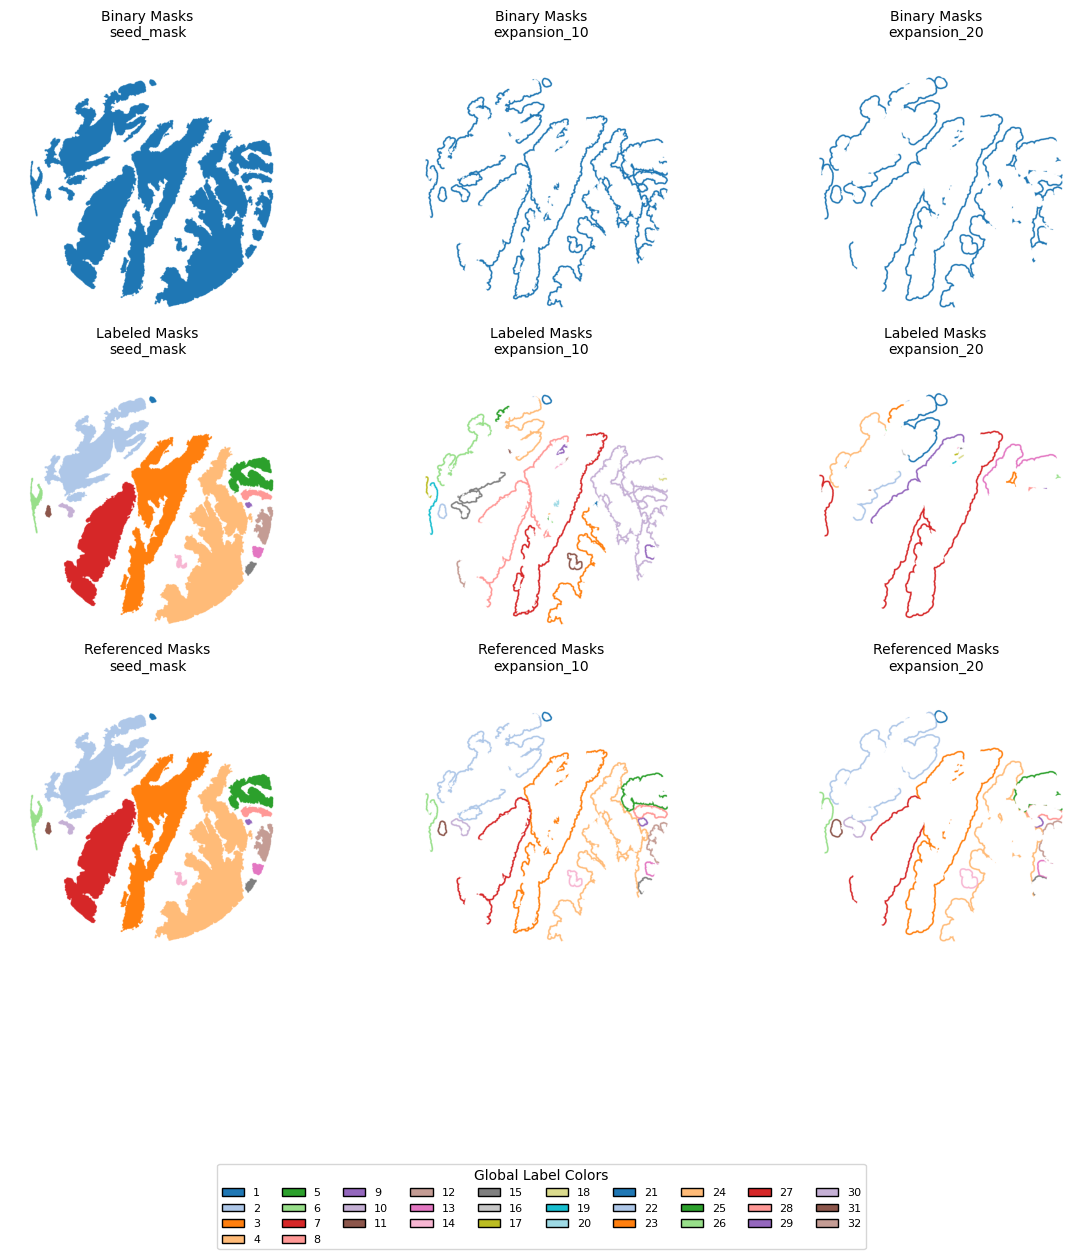

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.patches import Patch

# Mask dictionaries from your object
dicts = {
    "Binary Masks": TA.binary_expansions,
    "Labeled Masks": TA.labeled_expansions,
    "Referenced Masks": TA.referenced_expansions,
}

# Keys to display
keys = ['seed_mask', 'expansion_10', 'expansion_20']
seed_labels = np.unique(dicts["Labeled Masks"]["expansion_10"])
seed_labels = seed_labels[seed_labels != 0]  # Remove background
all_labels = sorted(seed_labels)

cmap = cm.get_cmap('tab20', 20)
label_to_color = {label: cmap((label - 1) % 20) for label in all_labels}

# STEP 3 — Color mapping function
def map_labels_to_rgb(mask):
    rgb = np.ones(mask.shape + (4,), dtype=np.float32)  # white background
    for label, color in label_to_color.items():
        rgb[mask == label] = color
    return rgb

# STEP 4 — Plotting
n_rows = len(dicts)
n_cols = len(keys)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
if axs.ndim == 1:
    axs = axs.reshape((n_rows, n_cols))

for row_idx, (row_name, d) in enumerate(dicts.items()):
    for col_idx, key in enumerate(keys):
        mask = d[key]
        rgb_img = map_labels_to_rgb(mask)
        ax = axs[row_idx, col_idx]
        ax.imshow(rgb_img)
        ax.set_title(f"{row_name}\n{key}", fontsize=10)
        ax.axis('off')

# STEP 5 — Legend (for seed labels only)
legend_patches = [
    Patch(facecolor=label_to_color[label], edgecolor='black', label=str(label))
    for label in all_labels
]

fig.legend(
    handles=legend_patches,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(legend_patches), 10),
    fontsize=8,
    title="Global Label Colors"
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


***Hierarchy using Single Object Mask Expansion***

We will use putative γδ T cell areas iin CosMx

In [10]:
cosmx_path_s3 =  '../../cosmx_data/S3/S3/20230628_151317_S3/AnalysisResults/yxyz3r7ufm'

folder_names_s3 = [folder_name for folder_name in os.listdir(cosmx_path_s3) if
                os.path.isdir(os.path.join(cosmx_path_s3, folder_name))]


target_files_s3 = [
    os.path.join(cosmx_path_s3, folder, file)
    for folder in os.listdir(cosmx_path_s3)
    if os.path.isdir(os.path.join(cosmx_path_s3, folder))
    for file in os.listdir(os.path.join(cosmx_path_s3, folder))
    if '__target_call_coord.csv' in file
]

files_cosmx = natsorted(target_files_s3)
len(files_cosmx)

20

In [11]:
target_gd = ['TRGC1/TRGC2', 'TRDC']
target_ab = ['TRBC1/TRBC2', 'TRAC']

target_cd8 = ['CD8A','CD8B', 'TRBC1/TRBC2', 'TRAC']
target_cd4 = ['CD4']

target_tum = ['EPCAM', 'CEACAM6', 'CLDN4', 'CDH1', 'RNF43', 'SPINK1', 'SOX9', 'CD24', 'KRT19', 'AREG',
              'REG1A', 'AGR2', 'PLAC8', 'CALB1', 'S100P', 'ITGA6', 'DMBT1', 'DUSP4',
              'KRT8', 'S100A6', 'RPL37', 'RPL32', 'KRT18', 'OLFM4',
              'PRSS2', 'CD55', 'EPHB4', 'ADGRL1', 'KRT17', 'ITGB8', 'ADGRE5', 'GDF15', 'IL27RA', 'AZGP1'
              ]  # cadherin 'PIGR',  'LYZ','SERPINA1'

density_th_gd = 2
min_area_th_gd = 5  # 40
kernel_size_gd = 45 #90 

In [12]:
fov = 'FOV010'
file_csv = [file for file in files_cosmx if fov in file][0]  
    
df_total = pd.read_csv(file_csv)
df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                   target_dict_total,
                                                                                   target_list=target_gd,
                                                                           target_col='target')

df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_ab,
                                                                                       target_col='target')
    
    
df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRGC1/TRGC2'],
                                                                                       target_col='target')
    
df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRDC'],
                                                                                       target_col='target')


df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=target_cd8,
                                                                                      target_col='target')
                                                                               

df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1/TRBC2'],
                                                                                      target_col='target')


df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD8A', 'CD8B'],
                                                                                      target_col='target')

df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD4'],
                                                                                      target_col='target')

In [13]:
CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

### Filtering 
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1


2025-06-19 23:51:57,741 - contour_logger - INFO - Initialized GetContour
2025-06-19 23:51:58,156 - contour_logger - INFO - get_conv_sum took 0.4139 seconds
2025-06-19 23:51:58,374 - contour_logger - INFO - Number of contours after filtering no counts: 26
2025-06-19 23:51:58,374 - contour_logger - INFO - contours_from_sum took 0.2178 seconds
2025-06-19 23:51:59,317 - contour_logger - INFO - Excluding contour 7. gd count 3.00 ≤ ab count 4.00
2025-06-19 23:51:59,719 - contour_logger - INFO - Excluding contour 13. gd count 1.00 ≤ ab count 2.00
2025-06-19 23:51:59,785 - contour_logger - INFO - Excluding contour 14. gd count 3.00 ≤ ab count 3.00
2025-06-19 23:52:00,514 - contour_logger - INFO - Contours remaining after gene comparison: 23
2025-06-19 23:52:00,580 - contour_logger - INFO - Excluding contour 1. Gene TRDC count  0.0 is below threshold 1
2025-06-19 23:52:00,613 - contour_logger - INFO - Excluding contour 2. Gene TRDC count  0.0 is below threshold 1
2025-06-19 23:52:01,004 - conto

In [14]:
GM = get_masks.GetMasks(image_shape=(height, width))

SA = get_masks.SingleClassObjectAnalysis(GM,contours_object=CGD.contours)
SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

SA.get_objects_expansion(expansions_pixels=[10, 20, 30],)  

2025-06-19 23:52:01,941 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks
2025-06-19 23:52:01,943 - gridgen.get_masks.GetMasks - INFO - Mask for objects created.


In [15]:
#  1. Define your masks using MaskDefinition
mask_definitions = [
    MaskDefinition(mask=SA.binary_expansions['seed_mask'], mask_name='GD', analysis_type='per_object'),
    MaskDefinition(mask=SA.binary_expansions['expansion_10'], mask_name='GD_10um', analysis_type='per_object'),
    MaskDefinition(mask=SA.binary_expansions['expansion_20'], mask_name='GD_20um', analysis_type='per_object'),
    MaskDefinition(mask=SA.binary_expansions['expansion_30'], mask_name='GD_30um', analysis_type='per_object'),

]

# 2. Initialize and run the analysis pipeline
pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                array_counts = array_total,
                        target_dict = target_dict_total,
  )
results = pipeline.run()
df = pipeline.get_results_df()
df


hierarchy_defs = {
        "GD": {
        "labels": SA.referenced_expansions['seed_mask'],
        "level_hierarchy": "GD"
    }, 
    "GD_10um": {
        "labels": SA.referenced_expansions['expansion_10'],
        "level_hierarchy": "GD"
    },
    "GD_20um": {
        "labels": SA.referenced_expansions['expansion_20'],
        "level_hierarchy": "GD"
    },
    "GD_30um": {
    "labels": SA.referenced_expansions['expansion_30'],
    "level_hierarchy": "GD"
    }
}
    
df_hierarchy = pipeline.map_hierarchies(hierarchy_defs, save_dir=None)
df_hierarchy

2025-06-19 23:52:05,112 - gridgen.mask_properties.GetMasks - INFO - Initialized MaskAnalysisPipeline with 4 masks.
2025-06-19 23:52:05,113 - gridgen.mask_properties.GetMasks - INFO - Processing mask: GD (per_object)
2025-06-19 23:52:21,889 - gridgen.mask_properties.GetMasks - INFO - Processing mask: GD_10um (per_object)
2025-06-19 23:52:39,244 - gridgen.mask_properties.GetMasks - INFO - Processing mask: GD_20um (per_object)
2025-06-19 23:52:57,697 - gridgen.mask_properties.GetMasks - INFO - Processing mask: GD_30um (per_object)


run took 70.1832 seconds
map_hierarchies took 0.5748 seconds


,mask_name,object_id,parent_mask,parent_ids
0,GD,1,GD,[1]
1,GD,2,GD,[2]
2,GD,3,GD,[3]
3,GD,4,GD,[4]
4,GD,5,GD,[5]
5,GD,6,GD,[6]
6,GD,7,GD,[7]
7,GD,8,GD,[8]
8,GD_10um,1,GD,[1]
9,GD_10um,2,GD,[2]


/tmp/ipykernel_784325/1730548250.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 20)


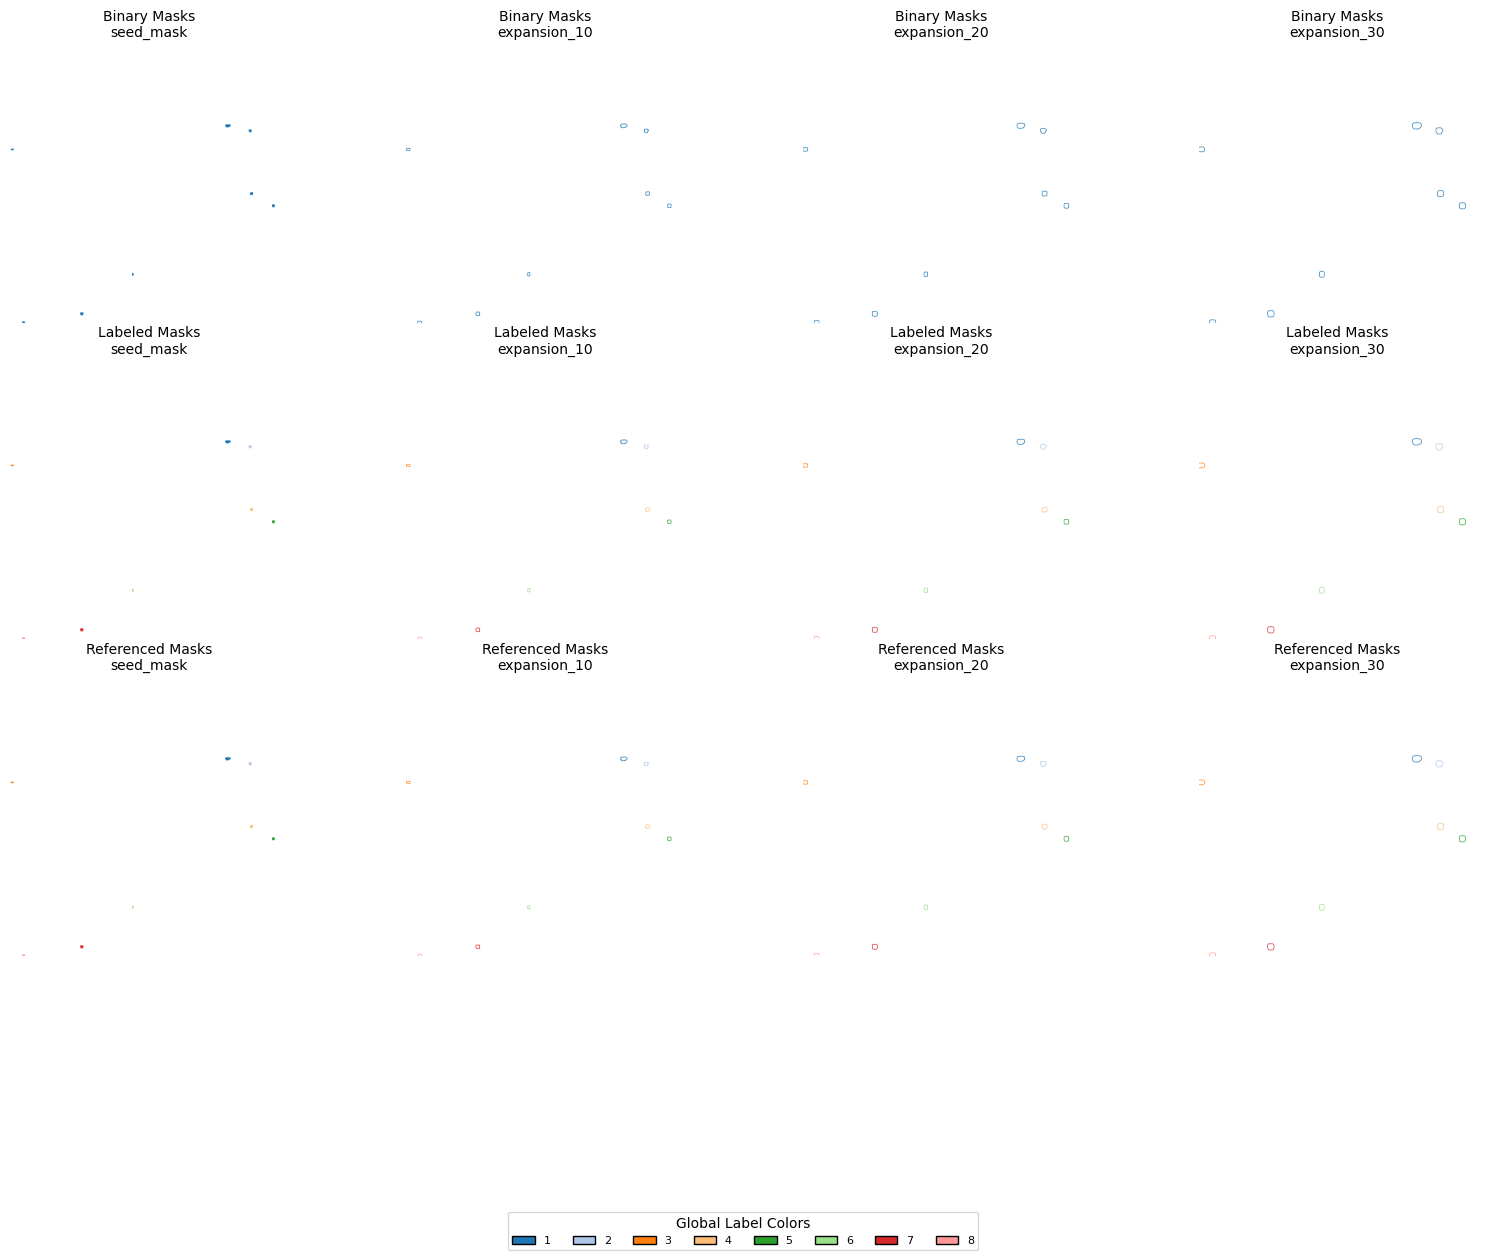

In [16]:
# Mask dictionaries from your object
dicts = {
    "Binary Masks": SA.binary_expansions,
    "Labeled Masks": SA.labeled_expansions,
    "Referenced Masks": SA.referenced_expansions,
}

# Keys to display
keys = ['seed_mask', 'expansion_10', 'expansion_20', 'expansion_30']
seed_labels = np.unique(dicts["Labeled Masks"]["expansion_10"])
seed_labels = seed_labels[seed_labels != 0]  # Remove background
all_labels = sorted(seed_labels)

cmap = cm.get_cmap('tab20', 20)
label_to_color = {label: cmap((label - 1) % 20) for label in all_labels}

# STEP 3 — Color mapping function
def map_labels_to_rgb(mask):
    rgb = np.ones(mask.shape + (4,), dtype=np.float32)  # white background
    for label, color in label_to_color.items():
        rgb[mask == label] = color
    return rgb

# STEP 4 — Plotting
n_rows = len(dicts)
n_cols = len(keys)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
if axs.ndim == 1:
    axs = axs.reshape((n_rows, n_cols))

for row_idx, (row_name, d) in enumerate(dicts.items()):
    for col_idx, key in enumerate(keys):
        mask = d[key]
        rgb_img = map_labels_to_rgb(mask)
        ax = axs[row_idx, col_idx]
        ax.imshow(rgb_img)
        ax.set_title(f"{row_name}\n{key}", fontsize=10)
        ax.axis('off')

# STEP 5 — Legend (for seed labels only)
legend_patches = [
    Patch(facecolor=label_to_color[label], edgecolor='black', label=str(label))
    for label in all_labels
]

fig.legend(
    handles=legend_patches,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=min(len(legend_patches), 10),
    fontsize=8,
    title="Global Label Colors"
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()
